In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import seaborn as sns
import sklearn.preprocessing 
import statsmodels as smt
from sklearn.preprocessing import scale 
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from IPython.display import clear_output
import itertools

In [2]:
! pip install function


In [4]:
import function as fct

In [3]:
#chemin jérémie
enedis_final = pd.read_csv("/Users/jeremiedarracq/Stat-app/enedis_final.csv",sep=",")

In [39]:
meteo_reg_df=pd.read_csv("/Users/jeremiedarracq/Stat-app/temperature_reg.csv",";")

## I - Régression linéaire simple 
Objectif : Prédiction du Total d'énergie soutirée par journée en fonction de la température de la journée sur une région particulière

Méthode : 
- On somme le total d'énergie soutirée par 1/2h sur une journée en agrégant tout les points de soutirages 
- On l'associe avec la température sur la journée 
- Réalisation d'une régression simple 

### Régression Haut-de-France

In [40]:
## On somme le total d'énergie sur la journée pour l'HDF 
enedis_HDF = enedis_final.loc[enedis_final.region_x == "Hauts-de-France"]
enedis_HDF_new = enedis_HDF.groupby("horodate")["total_energie_soutiree_wh"].sum().reset_index()
enedis_HDF_new["date"]= enedis_HDF_new["horodate"].apply(lambda x : x[0:10])
meteo_reg_df_HDF = meteo_reg_df[meteo_reg_df.region=="Hauts-de-France"]
enedis_HDF_new

,horodate,total_energie_soutiree_wh,date
0,2020-06-04T00:00:00+00:00,9.160308e+08,2020-06-04
1,2020-06-04T00:30:00+00:00,5.441395e+08,2020-06-04
2,2020-06-04T01:00:00+00:00,2.715486e+08,2020-06-04
3,2020-06-04T01:30:00+00:00,3.130624e+08,2020-06-04
4,2020-06-04T02:00:00+00:00,1.903883e+08,2020-06-04
...,...,...,...
20972,2021-08-14T22:00:00+00:00,1.144036e+09,2021-08-14
20973,2021-08-14T22:30:00+00:00,9.698766e+08,2021-08-14
20974,2021-08-14T23:00:00+00:00,9.488306e+08,2021-08-14
20975,2021-08-14T23:30:00+00:00,9.425433e+08,2021-08-14


In [41]:
## On change l'unité de mesure en Méga Watt et on fusionne avec les données de températures
enedis_prev_HDF = enedis_HDF_new.groupby("date")["total_energie_soutiree_wh"].sum().reset_index()
enedis_prev_HDF["total_energie_soutiree_wh"]=enedis_prev_HDF["total_energie_soutiree_wh"]*(10**(-6))
enedis_prev_HDF_cleen = enedis_prev_HDF.merge(meteo_reg_df_HDF,on = "date")
enedis_prev_HDF_cleen

,date,total_energie_soutiree_wh,id,code_insee_region,region,tmin,tmax,tmoy
0,2020-06-04,21847.594510,2020-06-04T00:00:00-32,32,Hauts-de-France,11.54,15.78,13.66
1,2020-06-05,20817.025872,2020-06-05T00:00:00-32,32,Hauts-de-France,10.40,16.08,13.24
2,2020-06-06,25166.758026,2020-06-06T00:00:00-32,32,Hauts-de-France,8.98,15.80,12.39
3,2020-06-07,21494.347189,2020-06-07T00:00:00-32,32,Hauts-de-France,9.66,18.70,14.18
4,2020-06-08,22576.935193,2020-06-08T00:00:00-32,32,Hauts-de-France,9.66,15.82,12.74
...,...,...,...,...,...,...,...,...
432,2021-08-11,41337.412850,2021-08-11T00:00:00-32,32,Hauts-de-France,11.88,23.08,17.48
433,2021-08-12,41560.951592,2021-08-12T00:00:00-32,32,Hauts-de-France,13.42,25.78,19.60
434,2021-08-13,42283.137259,2021-08-13T00:00:00-32,32,Hauts-de-France,13.68,23.24,18.46
435,2021-08-14,43319.561377,2021-08-14T00:00:00-32,32,Hauts-de-France,11.82,25.22,18.52


Pente :  [[-1635.21676496]]
Ordonnée à l'origine :  [53541.34718912]
Racine carrée de l'erreur quadratique moyenne :  39906218.60273409
Sccore R2 :  0.7241690773230539


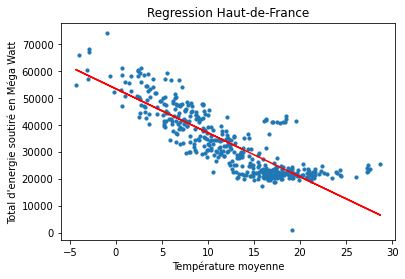

In [42]:
## Modèle de regression 
x = enedis_prev_HDF_cleen[["tmoy"]]
y = enedis_prev_HDF_cleen[["total_energie_soutiree_wh"]]
# initialisation du modèle
regression_model = LinearRegression()
# Adapter les données (entraînement du modèle)
regression_model.fit(x, y)
# Prédiction
y_predicted = regression_model.predict(x)
# Évaluation du modèle
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)
# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Sccore R2 : ', r2)
# Tracée des valeurs
# Points de données
plt.scatter(x, y, s=10)
plt.xlabel('Température moyenne')
plt.ylabel("Total d'energie soutiré en Méga Watt")
plt.title("Regression Haut-de-France")
# Valeurs prédites
plt.plot(x, y_predicted, color='r')
plt.show()

### Régression Occitanie

In [218]:
## On somme le total d'énergie sur la journée pour l'Occitanie
enedis_Occitanie = enedis_final.loc[enedis_final.region_x == "Occitanie"]
enedis_Occitanie_new = enedis_Occitanie.groupby("horodate")["total_energie_soutiree_wh"].sum().reset_index()
enedis_Occitanie_new["date"]= enedis_Occitanie_new["horodate"].apply(lambda x : x[0:10])
meteo_reg_df_Occitanie = meteo_reg_df[meteo_reg_df.region=="Occitanie"]

In [219]:
## On change l'unité de mesure en Méga Watt et on fusionne avec les données de températures
enedis_prev_Occitanie = enedis_Occitanie_new.groupby("date")["total_energie_soutiree_wh"].sum().reset_index()
enedis_prev_Occitanie["total_energie_soutiree_wh"]=enedis_prev_Occitanie["total_energie_soutiree_wh"]*(10**(-6))
enedis_prev_Occitanie_cleen = enedis_prev_Occitanie.merge(meteo_reg_df_Occitanie,on = "date")


Pente :  [[-1886.44280707]]
Ordonnée à l'origine :  [72708.99485089]
Racine carrée de l'erreur quadratique moyenne :  93478188.08200052
Sccore R2 :  0.6264917083980056


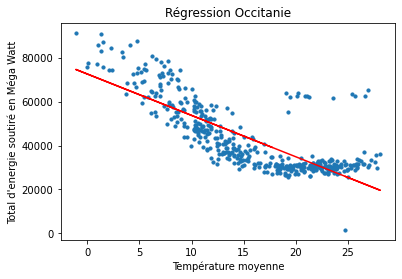

In [220]:
## Modèle de regression 
x = enedis_prev_Occitanie_cleen[["tmoy"]]
y = enedis_prev_Occitanie_cleen[["total_energie_soutiree_wh"]]
# initialisation du modèle
regression_model = LinearRegression()
# Adapter les données (entraînement du modèle)
regression_model.fit(x, y)
# Prédiction
y_predicted = regression_model.predict(x)
# Évaluation du modèle
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)
# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Sccore R2 : ', r2)
# Tracée des valeurs
# Points de données
plt.scatter(x, y, s=10)
plt.xlabel('Température moyenne')
plt.ylabel("Total d'energie soutiré en Méga Watt")
plt.title("Régression Occitanie")
# Valeurs prédites
plt.plot(x, y_predicted, color='r')
plt.show()

### Regression Ile de France 

In [29]:
## On somme le total d'énergie sur la journée pour l'Occitanie
enedis_IDF = enedis_final.loc[enedis_final.region_x == "Île-de-France"]
enedis_IDF_new = enedis_IDF.groupby("horodate")["total_energie_soutiree_wh"].sum().reset_index()
enedis_IDF_new["date"]= enedis_IDF_new["horodate"].apply(lambda x : x[0:10])
meteo_reg_df_IDF= meteo_reg_df[meteo_reg_df.region=="Île-de-France"]

In [30]:
## On change l'unité de mesure en Méga Watt et on fusionne avec les données de températures
enedis_prev_IDF = enedis_IDF_new.groupby("date")["total_energie_soutiree_wh"].sum().reset_index()
enedis_prev_IDF["total_energie_soutiree_MGh"]=enedis_prev_IDF["total_energie_soutiree_wh"]*(10**(-6))
enedis_prev_IDF_cleen = enedis_prev_IDF.merge(meteo_reg_df_IDF,on = "date")

Pente :  [[-2986.88830563]]
Ordonnée à l'origine :  [101969.04755821]
Racine carrée de l'erreur quadratique moyenne :  121118438.69056234
Sccore R2 :  0.7699816327643256


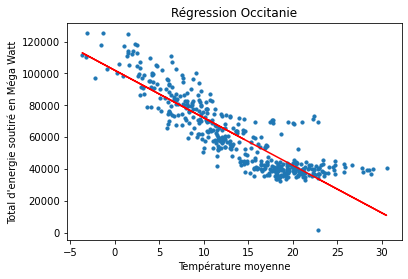

In [132]:
## Modèle de regression 
x = enedis_prev_IDF_cleen[["tmoy"]]
y = enedis_prev_IDF_cleen[["total_energie_soutiree_wh"]]
# initialisation du modèle
regression_model = LinearRegression()
# Adapter les données (entraînement du modèle)
regression_model.fit(x, y)
# Prédiction
y_predicted = regression_model.predict(x)
# Évaluation du modèle
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)
# Affichage des valeurs
print("Pente : " ,regression_model.coef_)
print("Ordonnée à l'origine : ", regression_model.intercept_)
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Sccore R2 : ', r2)
# Tracée des valeurs
# Points de données
plt.scatter(x, y, s=10)
plt.xlabel('Température moyenne')
plt.ylabel("Total d'energie soutiré en Méga Watt")
plt.title("Régression IDF")
# Valeurs prédites
plt.plot(x, y_predicted, color='r')
plt.show()

## II - Régression linéaire multiple
Objectif : Prédiction du Total d'énergie soutirée par journée en fonction de la température de la journée sur la France entière

Méthode : 
- On somme le total d'énergie soutirée par 1/2h sur une journée en agrégant tout les points de soutirages 
- On l'associe avec la région et la température de la région sur la journée 
- Réalisation d'une régression multiple

## III - Modèle ARIMA 
Objectif : Prédiction du Total d'énergie soutirée par journée en fonction de la température de la journée d'une région particulière en prenant en compte la composante temporelle 

Méthode : 
- On somme le total d'énergie soutirée par 1/2h sur une journée en agrégant tout les points de soutirages 
- On l'associe avec la région et la température de la région sur la journée 

### Modèle ARIMA HDF

==> voir si la série temporelles est stationnairte ou non ?

In [55]:
reqd_Index = list(np.where(enedis_prev_HDF_cleen["date"] == "2021-06-04"))
print(reqd_Index)

[array([364])]


In [56]:
enedis_prev_HDF_cleen = enedis_prev_HDF_cleen.iloc[:365]
enedis_prev_HDF_cleen

,date,total_energie_soutiree_wh,id,code_insee_region,region,tmin,tmax,tmoy,log total energie soutirée_MWh,log total energie soutirée_MWh minus_mean
0,2020-06-04,21847.594510,2020-06-04T00:00:00-32,32,Hauts-de-France,11.54,15.78,13.66,9.991846,NaN
1,2020-06-05,20817.025872,2020-06-05T00:00:00-32,32,Hauts-de-France,10.40,16.08,13.24,9.943526,NaN
2,2020-06-06,25166.758026,2020-06-06T00:00:00-32,32,Hauts-de-France,8.98,15.80,12.39,10.133279,NaN
3,2020-06-07,21494.347189,2020-06-07T00:00:00-32,32,Hauts-de-France,9.66,18.70,14.18,9.975545,NaN
4,2020-06-08,22576.935193,2020-06-08T00:00:00-32,32,Hauts-de-France,9.66,15.82,12.74,10.024684,NaN
...,...,...,...,...,...,...,...,...,...,...
360,2021-05-31,22452.243268,2021-05-31T00:00:00-32,32,Hauts-de-France,9.60,23.52,16.56,10.019146,-0.185770
361,2021-06-01,22515.198274,2021-06-01T00:00:00-32,32,Hauts-de-France,10.68,25.30,17.99,10.021946,-0.164217
362,2021-06-02,22858.802504,2021-06-02T00:00:00-32,32,Hauts-de-France,13.96,27.98,20.97,10.037092,-0.140458
363,2021-06-03,21217.713673,2021-06-03T00:00:00-32,32,Hauts-de-France,15.80,22.42,19.11,9.962592,-0.184563


In [57]:
rolling_mean = enedis_prev_HDF_cleen["total_energie_soutiree_wh"].rolling(window = 12).mean()
rolling_std = enedis_prev_HDF_cleen["total_energie_soutiree_wh"].rolling(window = 12).std()


<function matplotlib.pyplot.show(close=None, block=None)>

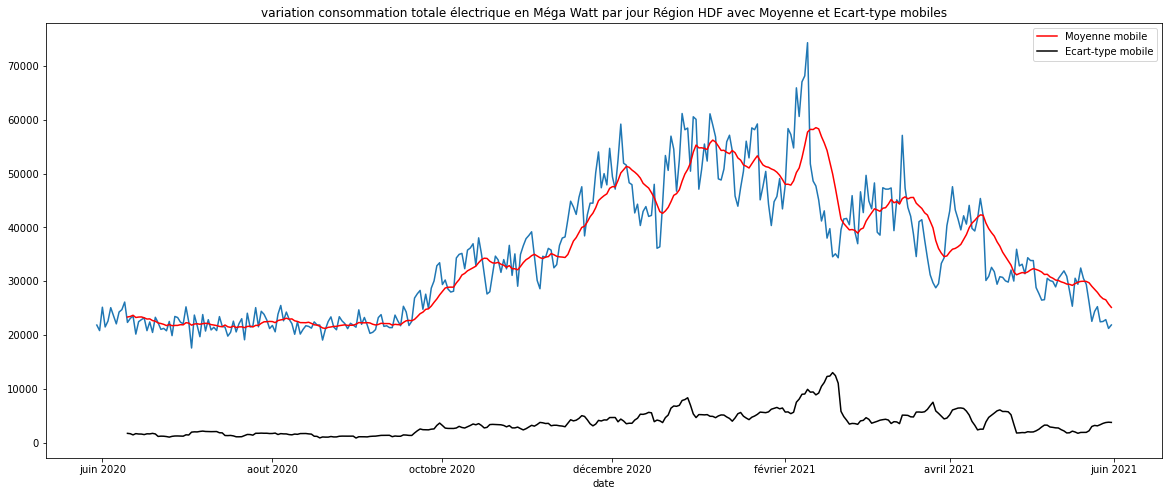

In [58]:
plt.figure(figsize=(20, 8))
plt.plot(enedis_prev_HDF_cleen["date"],enedis_prev_HDF_cleen["total_energie_soutiree_wh"])
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
plt.xlabel('date')
plt.legend(loc = 'best')
plt.title("variation consommation totale électrique en Méga Watt par jour Région HDF avec Moyenne et Ecart-type mobiles")
plt.show

In [59]:
result = adfuller(enedis_prev_HDF_cleen["total_energie_soutiree_wh"])
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -1.2039051703298667
p-value : 0.6719135541658365
Valeurs Critiques :
	1%: -3.4491725955218655
	5%: -2.8698334971428574
	10%: -2.5711883591836733


La p-valeur est très élevé (57%) donc la série temporelle n'est pas stationnaire 

In [60]:
## On veut transformer notre série temporelle en série stationnaire 
## Transformation en log
enedis_prev_HDF_cleen["log total energie soutirée_MWh"]= log = np.log(enedis_prev_HDF_cleen["total_energie_soutiree_wh"])

## On soustrait la moyenne mobile
rolling_mean = enedis_prev_HDF_cleen["log total energie soutirée_MWh"].rolling(window=12).mean()
enedis_prev_HDF_cleen["log total energie soutirée_MWh minus_mean"] = enedis_prev_HDF_cleen["log total energie soutirée_MWh"] - rolling_mean


<ipython-input-60-66a94ac71fa2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enedis_prev_HDF_cleen["log total energie soutirée_MWh"]= log = np.log(enedis_prev_HDF_cleen["total_energie_soutiree_wh"])
<ipython-input-60-66a94ac71fa2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enedis_prev_HDF_cleen["log total energie soutirée_MWh minus_mean"] = enedis_prev_HDF_cleen["log total energie soutirée_MWh"] - rolling_mean


<function matplotlib.pyplot.show(close=None, block=None)>

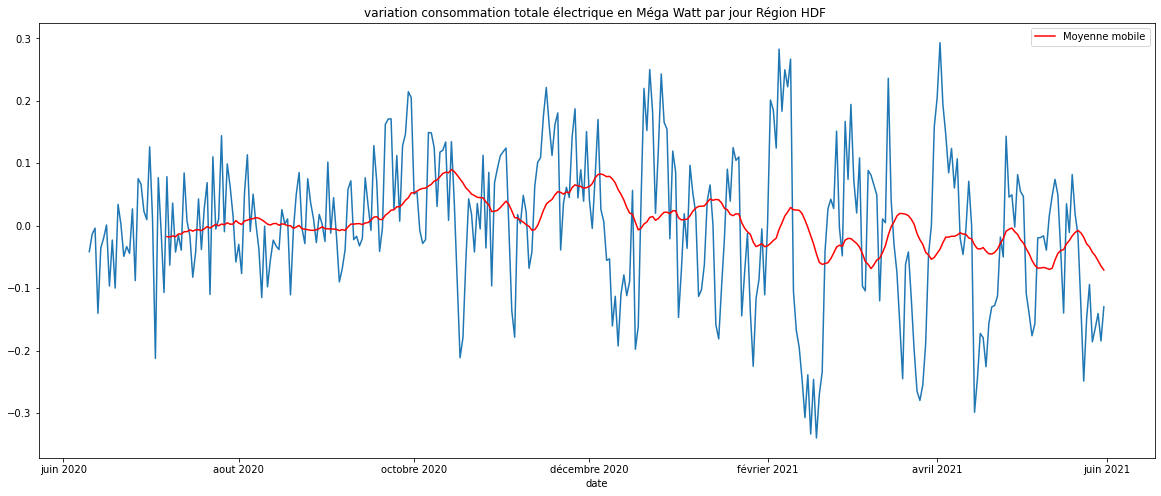

In [65]:
rolling_mean = enedis_prev_HDF_cleen["log total energie soutirée_MWh minus_mean"].rolling(window = 28).mean()
plt.figure(figsize=(20, 8))
plt.plot(enedis_prev_HDF_cleen["date"],enedis_prev_HDF_cleen["log total energie soutirée_MWh minus_mean"])
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
t2=["2020-06-06","2020-08-06","2020-10-06","2020-12-06","2021-02-06","2021-04-06","2021-06-06"]
plt.xticks(t2,["juin 2020","aout 2020","octobre 2020","décembre 2020","février 2021","avril 2021","juin 2021"])
plt.xlabel('date')
plt.legend(loc = 'best')
plt.title("variation consommation totale électrique en Méga Watt par jour Région HDF ")
plt.show

In [181]:
decomposition = seasonal_decompose(enedis_prev_HDF_cleen["log total energie soutirée_MWh minus_mean"]) 
model = ARIMA(enedis_prev_HDF_cleen["log total energie soutirée_MWh minus_mean"], order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(enedis_prev_HDF_cleen["log total energie soutirée_MWh minus_mean"])
plt.plot(results.fittedvalues, color='red')


ValueError: This function does not handle missing values

## Modèle ARIMA IDF 

## Stationnarité et différenciation de la série :
Nous sommes en présence d'une série temporelle marquée par une forte saisonnalité, très classique sur les températures climatiques. Il n'est pas possible de modéliser directement par un processus stationnaire, la stationnarisation du processus sera donc mise en oeuvre. La méthode retenue sera la différenciation.

In [5]:
reqd_Index = list(np.where(enedis_IDF_new["horodate"] == "2021-06-04T23:30:00+00:00"))
print(reqd_Index)

[array([17567])]


In [4]:
enedis_IDF = enedis_final.loc[enedis_final.region_x == "Île-de-France"]
enedis_IDF_new = enedis_IDF.groupby("horodate")["total_energie_soutiree_wh"].sum().reset_index()
enedis_IDF_ARIMA = enedis_IDF_new.iloc[:17568]
enedis_IDF_ARIMA["total_energie_soutiree_MGwh"]=enedis_IDF_new["total_energie_soutiree_wh"]*(10**(-6))
enedis_IDF_ARIMA = enedis_IDF_ARIMA.drop(columns="total_energie_soutiree_wh")
enedis_IDF_ARIMA


<ipython-input-4-804c59851f10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enedis_IDF_ARIMA["total_energie_soutiree_MGwh"]=enedis_IDF_new["total_energie_soutiree_wh"]*(10**(-6))


,horodate,total_energie_soutiree_MGwh
0,2020-06-04T00:00:00+00:00,1492.533784
1,2020-06-04T00:30:00+00:00,854.244472
2,2020-06-04T01:00:00+00:00,784.451164
3,2020-06-04T01:30:00+00:00,445.561972
4,2020-06-04T02:00:00+00:00,564.224376
...,...,...
17563,2021-06-04T21:30:00+00:00,1468.255088
17564,2021-06-04T22:00:00+00:00,678.437458
17565,2021-06-04T22:30:00+00:00,188.824608
17566,2021-06-04T23:00:00+00:00,1025.573611


## La tendance 


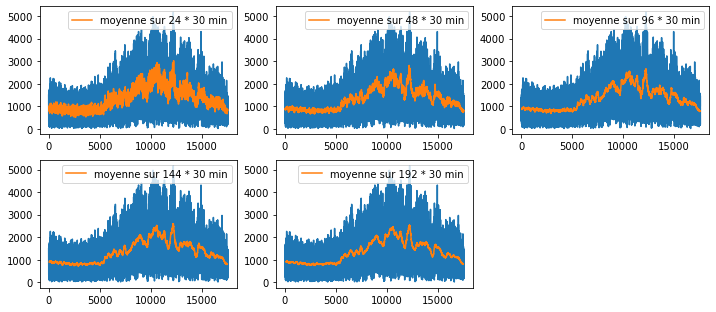

In [6]:
y = enedis_IDF_ARIMA["total_energie_soutiree_MGwh"]
win = [24, 48, 96,144,192]
fig = plt.figure(figsize=(12,8))

for i in range(len(win)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(y)
    ax.plot(y.rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} * 30 min")
    ax.legend()

## La saisonnalité 

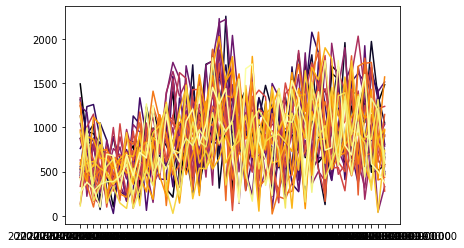

In [7]:
colors = plt.cm.inferno(np.linspace(0,1,31))
day= [m for m in range(0,49)]
for i in range(31):
    plt.plot(enedis_IDF_ARIMA["horodate"].iloc[0:47],enedis_IDF_ARIMA["total_energie_soutiree_MGwh"].iloc[48*i:48*i+47],color=colors[i])




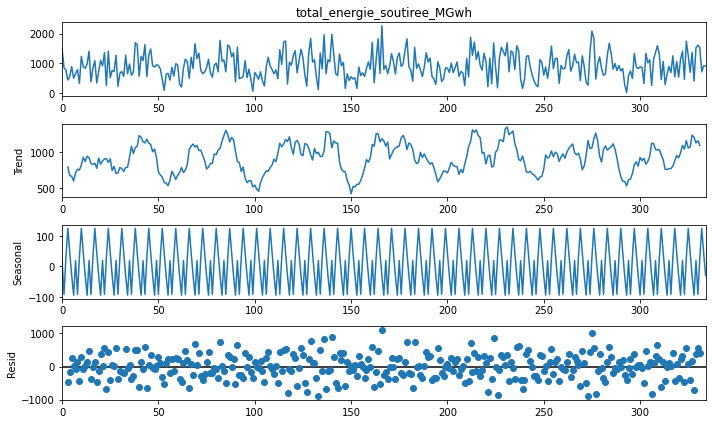

In [47]:
enedis_IDF_ARIMA_1sem= enedis_IDF_ARIMA.iloc[0:335]
decomposition_1sem = seasonal_decompose(enedis_IDF_ARIMA_1sem["total_energie_soutiree_MGwh"],period=7) 
fig = decomposition_1sem.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

In [48]:
decomposition_1sem.seasonal[0:16]

0      18.768046
1     -91.566060
2      28.964393
3     124.481536
4      44.332020
5     -30.534380
6     -94.445556
7      18.768046
8     -91.566060
9      28.964393
10    124.481536
11     44.332020
12    -30.534380
13    -94.445556
14     18.768046
15    -91.566060
Name: seasonal, dtype: float64

In [49]:
y_1sem = enedis_IDF_ARIMA_1sem["total_energie_soutiree_MGwh"]
y_1sem_diff_7= y_1sem- y_1sem.shift(7)

In [50]:
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    """
        Test de Dickey–Fuller 
        avec Autocorrélogrammes ACF et PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

/Users/jeremiedarracq/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


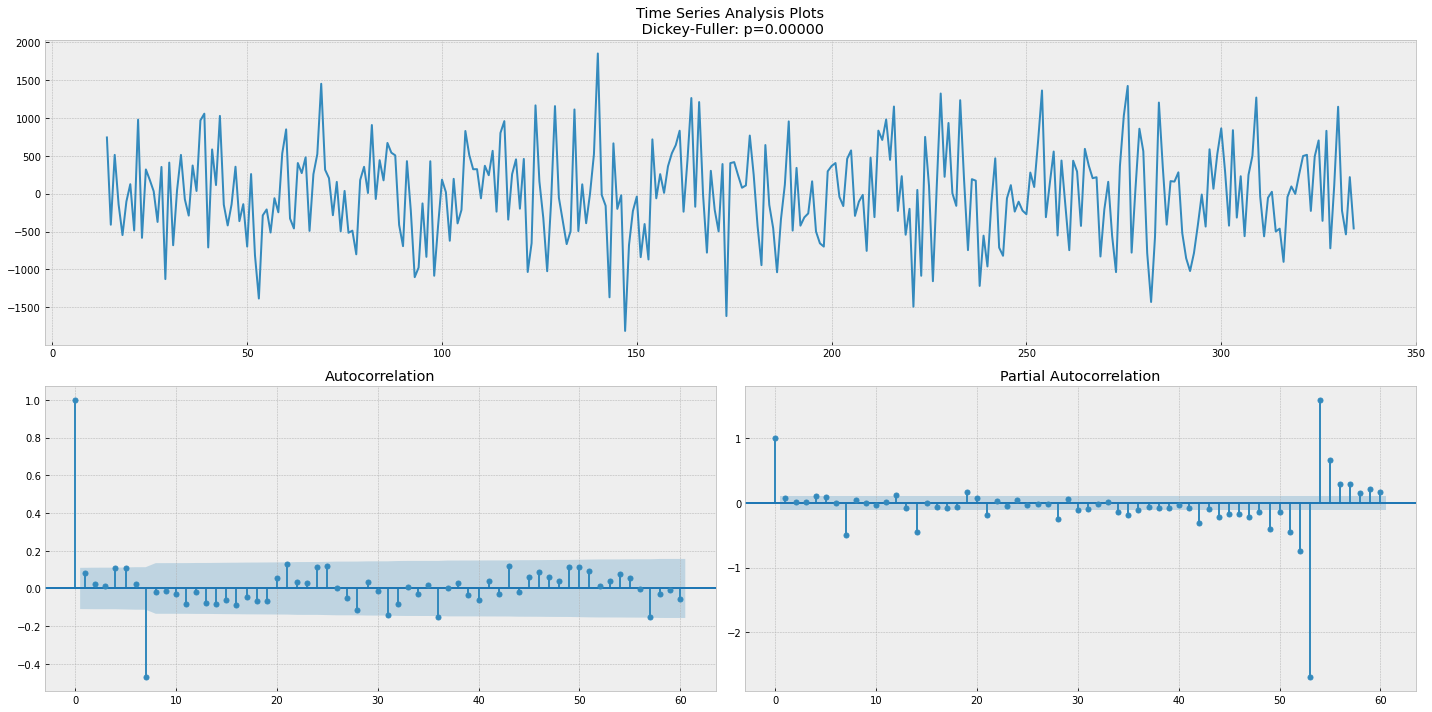

In [51]:
y_1sem_diff_7 = y_1sem_diff_7.dropna()
tsplot(y_1sem_diff_7[7:], lags=60)

In [52]:
#Détermination du meilleur modèle de prévision 
from time import time
DUREE_PREDITE = 48 #prédiction sur un jour
troncature = DUREE_PREDITE
y = enedis_IDF_ARIMA_1sem["total_energie_soutiree_MGwh"]
y_prevision = y[-troncature:]

#Calcul de toutes les combinaisons de p, d et q
pdq_list = list(itertools.product(range(3),
                             range(2), 
                             range(3)
           ))

#Calcul de toutes les combinaisons de P, D et Q
PDQ_list = [ (*val, 7) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]


#Nombre de configurations total pour un modèle SARIMA
n = len(pdq_list) * len(PDQ_list)

#Dataframe pour stockage des valeurs
results_SARIMA = pd.DataFrame({'modele':[], 'aic':[], 'bic':[], 'ljungbox':[], 'pvalues':[]})
counter = 1
s_time = time()

#Itération sur toutes les combinaisons
for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            #Instanciation et entrainement du modèle SARIMA
            mod = SARIMAX(np.asarray(y), order = pdq, seasonal_order = PDQ, 
                          enforce_stationarity=False, enforce_invertibility=False)
            result = mod.fit()
                    
            #Intégration des indicateurs dans le précédent dataframe
            results_SARIMA = results_SARIMA.append({'modele':f"{pdq}x{PDQ}", 
                            'aic': result.aic, 
                            'bic': result.bic,
                            'ljungbox': acorr_ljungbox(result.resid, lags=7)[1].mean(),
                            'pvalues': result.pvalues.min()}, 
                            ignore_index=True)
        except:
            continue
            
        clear_output(' ')
        print(f"{counter}/{n} - {time() - s_time:.0f}s")
        counter += 1

324/324 - 189s


In [53]:
#Sélection des modèles SARIMA les plus optimaux selon les tests de significativité des paramètres 
#et de blancheur du résidu sont validés au niveau 5%
results_SARIMA_filter = results_SARIMA[(results_SARIMA['ljungbox'] > 0.05)]
results_SARIMA_filter = results_SARIMA_filter[results_SARIMA_filter['pvalues'] < 0.05]

In [54]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
results_SARIMA_filter['rank_aic'] = results_SARIMA_filter['aic'].rank(ascending=True)
results_SARIMA_filter['rank_bic'] = results_SARIMA_filter['bic'].rank(ascending=True)

In [55]:
#Visualisation des 30 modèles les plus performants sur les 324 initiaux
def highlight_greaterthan(x):
    if x.rank_aic == 25:
        return ['background-color: #2399f9']*7
    else:
        return ['background-color: None']*7

results_SARIMA_filter.sort_values('rank_aic', ascending=True)[:30].style.apply(highlight_greaterthan, axis=1)

,modele,aic,bic,ljungbox,pvalues,rank_aic,rank_bic
107,"(0, 1, 2)x(2, 1, 2, 7)",4660.622225,4686.778231,0.226665,0.001739,1.000000,4.000000
101,"(0, 1, 2)x(1, 1, 2, 7)",4663.399217,4685.818651,0.249151,0.017649,2.000000,2.000000
95,"(0, 1, 2)x(0, 1, 2, 7)",4664.921975,4683.604836,0.180739,0.000000,3.000000,1.000000
53,"(0, 0, 2)x(2, 1, 2, 7)",4665.128458,4691.307008,0.394365,0.000000,4.000000,7.000000
161,"(1, 0, 2)x(2, 1, 2, 7)",4665.875207,4695.793550,0.436593,0.000000,5.000000,10.000000
41,"(0, 0, 2)x(0, 1, 2, 7)",4667.229191,4685.928155,0.513252,0.000000,6.000000,3.000000
47,"(0, 0, 2)x(1, 1, 2, 7)",4668.429370,4690.868128,0.378944,0.000000,7.000000,5.000000
149,"(1, 0, 2)x(0, 1, 2, 7)",4668.819493,4691.258250,0.434337,0.000000,8.000000,6.000000
155,"(1, 0, 2)x(1, 1, 2, 7)",4669.083412,4695.261962,0.491177,0.000000,9.000000,9.000000
203,"(1, 1, 2)x(0, 1, 2, 7)",4669.353444,4691.772878,0.133942,0.000000,10.000000,8.000000


Selon la minimisation du critère AIC et BIC , le modèle (2, 0, 0)x(2, 1, 1, 7) ressort comme étant le plus optimal. Ce choix a été fait après plusieurs tests sur plusieurs modèles, il ressort comme étant le plus performant en tenant compte également de la significativité des paramètres, ainsi que la blancheur du résidu estimée à l'aide du test de Ljung–Box. Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.


In [56]:
#Instanciation et entrainement du modèle SARIMA via statsmodels
model = SARIMAX(np.asarray(y), order=(2,0,0), seasonal_order=(2,1,1,7))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  335
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 7)   Log Likelihood               -2456.071
Date:                             Mon, 06 Feb 2023   AIC                           4924.142
Time:                                     23:15:39   BIC                           4946.900
Sample:                                          0   HQIC                          4933.221
                                             - 335                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1016      0.057      1.798      0.072      -0.009       0.212
ar.L2          0.0958      

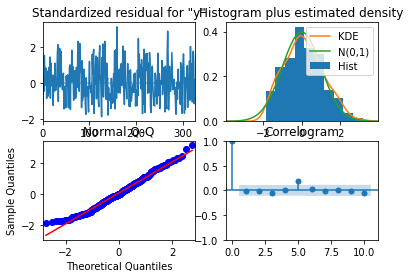

In [58]:
#La fonction .plot_diagnostics() permet d'établir un diagnostic rapide du modèle SARIMA identifié  
fig = results.plot_diagnostics()

### SARIMA SUR L'ANNEE 

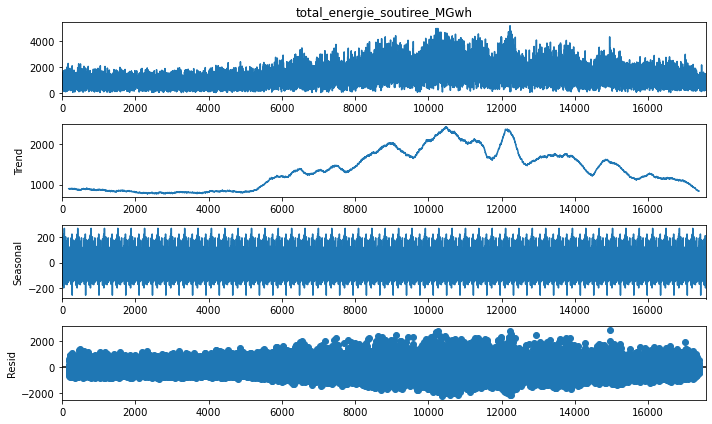

In [29]:
decomposition = seasonal_decompose(enedis_IDF_ARIMA["total_energie_soutiree_MGwh"],period=365) 
fig = decomposition.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

In [30]:
decomposition.seasonal[0:16]

0      90.887644
1      11.108083
2    -120.878856
3     -78.588428
4      36.868583
5     -67.901323
6      90.169155
7      -1.178522
8     118.485732
9    -110.729624
10   -174.469417
11    183.948537
12    109.249681
13    -26.228998
14     64.177347
15     -5.817249
Name: seasonal, dtype: float64

On voit que la saisonnalité est de 7

### Stationnariser la série

In [11]:
y_diff_7= y - y.shift(7)

In [13]:
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    """
        Test de Dickey–Fuller 
        avec Autocorrélogrammes ACF et PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

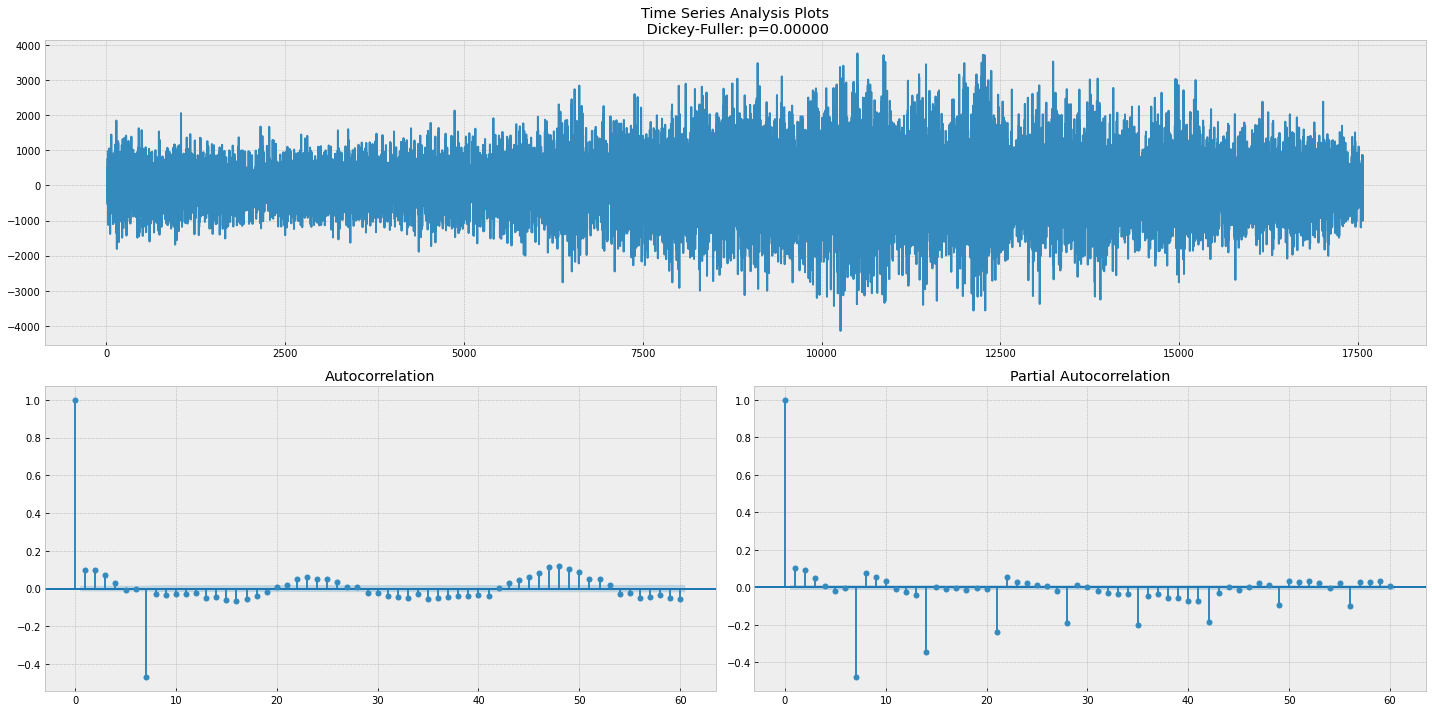

In [14]:
y_diff_7 = y_diff_7.dropna()
tsplot(y_diff_7[7:], lags=60)


## Génération d'une configuration optimale SARIMA :

L’identification des combinaisons sera faite par l’approche d’optimisation des polynômes AR et MA. Nous cherchons à minimiser le critère d’information d’Akaike AIC pour déterminer les ordres optimaux. La blancheur et normalité du résidu est également un critère à prendre en compte.

In [15]:
#Détermination du meilleur modèle de prévision 
from time import time
DUREE_PREDITE = 336 #prédiction sur une semaine
troncature = DUREE_PREDITE
y = enedis_IDF_ARIMA["total_energie_soutiree_MGwh"]
y_prevision = y[-troncature:]

#Calcul de toutes les combinaisons de p, d et q
pdq_list = list(itertools.product(range(3),
                             range(2), 
                             range(3)
           ))

#Calcul de toutes les combinaisons de P, D et Q
PDQ_list = [ (*val, 7) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]


#Nombre de configurations total pour un modèle SARIMA
n = len(pdq_list) * len(PDQ_list)

#Dataframe pour stockage des valeurs
results_SARIMA = pd.DataFrame({'modele':[], 'aic':[], 'bic':[], 'ljungbox':[], 'pvalues':[]})
counter = 1
s_time = time()

#Itération sur toutes les combinaisons
for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            #Instanciation et entrainement du modèle SARIMA
            mod = SARIMAX(np.asarray(y), order = pdq, seasonal_order = PDQ, 
                          enforce_stationarity=False, enforce_invertibility=False)
            result = mod.fit()
                    
            #Intégration des indicateurs dans le précédent dataframe
            results_SARIMA = results_SARIMA.append({'modele':f"{pdq}x{PDQ}", 
                            'aic': result.aic, 
                            'bic': result.bic,
                            'ljungbox': acorr_ljungbox(result.resid, lags=365)[1].mean(),
                            'pvalues': result.pvalues.min()}, 
                            ignore_index=True)
        except:
            continue
            
        clear_output(' ')
        print(f"{counter}/{n} - {time() - s_time:.0f}s")
        counter += 1

324/324 - 14645s


In [17]:
#Sélection des modèles SARIMA les plus optimaux selon les tests de significativité des paramètres 
#et de blancheur du résidu sont validés au niveau 5%
results_SARIMA_filter = results_SARIMA[(results_SARIMA['ljungbox'] > 0.05)]
results_SARIMA_filter = results_SARIMA_filter[results_SARIMA_filter['pvalues'] < 0.05]

In [18]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
results_SARIMA_filter['rank_aic'] = results_SARIMA_filter['aic'].rank(ascending=True)
results_SARIMA_filter['rank_bic'] = results_SARIMA_filter['bic'].rank(ascending=True)

In [19]:
#Visualisation des 30 modèles les plus performants sur les 324 initiaux
def highlight_greaterthan(x):
    if x.rank_aic == 25:
        return ['background-color: #2399f9']*7
    else:
        return ['background-color: None']*7

results_SARIMA_filter.sort_values('rank_aic', ascending=True)[:30].style.apply(highlight_greaterthan, axis=1)

,modele,aic,bic,ljungbox,pvalues,rank_aic,rank_bic
308,"(2, 1, 2)x(0, 0, 2, 7)",275318.249134,275372.658798,0.780495,0.000000,1.000000,1.000000
314,"(2, 1, 2)x(1, 0, 2, 7)",275321.336602,275383.519076,0.813934,0.000000,2.000000,2.000000
320,"(2, 1, 2)x(2, 0, 2, 7)",275323.040468,275392.995751,0.806406,0.000000,3.000000,4.000000
318,"(2, 1, 2)x(2, 0, 0, 7)",275333.626801,275388.036865,0.781411,0.000000,4.000000,3.000000
319,"(2, 1, 2)x(2, 0, 1, 7)",275336.990644,275399.173574,0.761680,0.000000,5.000000,5.000000
307,"(2, 1, 2)x(0, 0, 1, 7)",275428.872183,275475.511431,0.745697,0.000000,6.000000,6.000000
313,"(2, 1, 2)x(1, 0, 1, 7)",275430.925330,275485.337786,0.654330,0.000000,7.000000,7.000000
312,"(2, 1, 2)x(1, 0, 0, 7)",275444.385478,275491.025068,0.747161,0.000000,8.000000,8.000000
149,"(1, 0, 2)x(0, 1, 2, 7)",275454.815935,275501.450738,0.956139,0.000000,9.000000,9.000000
239,"(2, 0, 1)x(0, 1, 2, 7)",275470.062484,275516.697630,0.953094,0.000000,10.000000,10.000000


Selon la minimisation du critère AIC et BIC , le modèle (2, 0, 1)x(2, 0, 2, 7) ressort comme étant le plus optimal. Ce choix a été fait après plusieurs tests sur plusieurs modèles, il ressort comme étant le plus performant en tenant compte également de la significativité des paramètres, ainsi que la blancheur du résidu estimée à l'aide du test de Ljung–Box. Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.


In [20]:
#Instanciation et entrainement du modèle SARIMA via statsmodels
model = SARIMAX(np.asarray(y), order=(2,0,1), seasonal_order=(2,0,2,7))
results = model.fit()
print(results.summary())

/Users/jeremiedarracq/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                17568
Model:             SARIMAX(2, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood             -137995.763
Date:                                Mon, 06 Feb 2023   AIC                         276007.527
Time:                                        22:30:29   BIC                         276069.717
Sample:                                             0   HQIC                        276028.002
                                              - 17568                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1118      0.007    163.554      0.000       1.098       1.125
ar.

Normalité des résidus :

Dans le cadre de prévisions, il convient de vérifier la normalité des résidus pour tester l'adéquation de nos modèles. La normalité peut-être détectée de façon graphique, mais des tests statistiques amènent un point de vue objectif non négligeable.

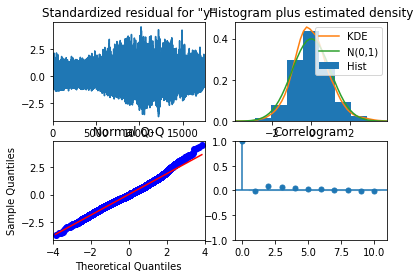

In [21]:
#La fonction .plot_diagnostics() permet d'établir un diagnostic rapide du modèle SARIMA identifié  
fig = results.plot_diagnostics()

La représentation "Standardized residual" et "Correlogram" confirment qu'il n'y a pas de corrélation des résidus. Les résidus sont normalement distribués KDE vs distribution normale - N (0,1). La distribution ordonnée des résidus représentée par le du Q-Q plot est t satisfaisant. Il est intéressant de coupler l'approche visuelle par des tests statistique

## MODÈLE DEEPAR 

In [ ]:
! pip install gluonts
! pip install "gluonts[torch,pro]"

     |████████████████████████████████| 980 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 825 kB 46.9 MB/s eta 0:00:01
     |████████████████████████████████| 135.4 MB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 143 kB 34.5 MB/s eta 0:00:01
     |████████████████████████████████| 192 kB 60.2 MB/s eta 0:00:01
     |████████████████████████████████| 517 kB 31.2 MB/s eta 0:00:01
     |████████████████████████████████| 359 kB 30.7 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 13.5 MB/s eta 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.8.3
    Uninstalling fsspec-0.8.3:
      Successfully uninstalled fsspec-0.8.3
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.3.1
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
import numpy as np 
import pandas as pd
import os


In [ ]:
## Transformation base de donnée 
enedis_IDF_new
enedis_IDF_deep = enedis_IDF_new.merge(meteo_reg_df_HDF,on = "date")

,horodate,total_energie_soutiree_wh,date
0,2020-06-04T00:00:00+00:00,1.492534e+09,2020-06-04
1,2020-06-04T00:30:00+00:00,8.542445e+08,2020-06-04
2,2020-06-04T01:00:00+00:00,7.844512e+08,2020-06-04
3,2020-06-04T01:30:00+00:00,4.455620e+08,2020-06-04
4,2020-06-04T02:00:00+00:00,5.642244e+08,2020-06-04
...,...,...,...
20972,2021-08-14T22:00:00+00:00,1.704726e+09,2021-08-14
20973,2021-08-14T22:30:00+00:00,1.477649e+09,2021-08-14
20974,2021-08-14T23:00:00+00:00,1.429661e+09,2021-08-14
20975,2021-08-14T23:30:00+00:00,1.401945e+09,2021-08-14


In [ ]:
reqd_Index = list(np.where(enedis_IDF_new["horodate"] == "2021-01-04T00:00:00+00:00"))
print(reqd_Index)

[array([10272])]


In [ ]:
enedis_prev_IDF_cleen
enedis_IDF_deepAR = enedis_prev_IDF_cleen.drop(columns = ["region","code_insee_region","tmax","tmin","total_energie_soutiree_wh","id"])
enedis_IDF_deepAR

,date,total_energie_soutiree_MGh,tmoy
0,2020-06-04,42925.772026,14.51
1,2020-06-05,42549.864524,14.20
2,2020-06-06,44403.071099,14.56
3,2020-06-07,44842.599933,14.22
4,2020-06-08,45033.804056,14.55
...,...,...,...
432,2021-08-11,69276.112437,21.02
433,2021-08-12,69748.122532,22.85
434,2021-08-13,71107.947594,22.28
435,2021-08-14,72920.041712,22.34


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.mx import DeepAREstimator, Trainer

### Préparation des données

In [ ]:
freq="30Min" ## rate at  which dataset is sampled
start_train = pd.Timestamp("2020-06-04T00:00:00+00:00", freq=freq) ## start index
start_test = pd.Timestamp("2021-01-04T00:00:00+00:00", freq=freq) ## start_index for test_set verify by df_all.columns[40000:].shape == df_test.shape

prediction_lentgh= 24 * 1 ## Our prediction Length is 1 Days 

In [ ]:
df_train=enedis_IDF_new.iloc[:,1:10272].values
df_test=enedis_IDF_new.iloc[:,20977:].values

In [ ]:
df_train.shape

(20977, 2)